In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.preprocessing import sequence
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
%matplotlib inline

# Load glove vectors

In [3]:
import bcolz
import re
from numpy.random import normal
import _pickle as pickle

def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

def load_array(fname):
    return bcolz.open(fname)[:]

In [4]:
glove_vecs, glove_words, glove_wordidx = load_vectors('/data/glove/results/6B.300d')
glove_vec_len = len(glove_vecs[0])
glove_vecs = np.append(glove_vecs, np.zeros((1,glove_vec_len)), axis=0)
glove_words.append('####')
glove_wordidx['####'] = len(glove_words) - 1

# Import training data

In [5]:
import csv

raw_train_data = []
raw_train_labels = []

with open('/data/spooky_author/train_ascii.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for lid, text, author in reader:
        raw_train_data.append(text)
        raw_train_labels.append(author)

## Tokenize and transform training data

In [6]:
from nltk.tokenize import word_tokenize

tokenized_train_data = list(map(lambda x: word_tokenize(x.lower()), raw_train_data))

In [7]:
wordid_train_data = []

for sentence in tqdm(tokenized_train_data):
    wordid_train_data.append([])
    for word in sentence: 
        if word in glove_wordidx:
            wordid_train_data[-1].append(glove_wordidx[word])
        

100%|██████████| 19579/19579 [00:00<00:00, 54289.98it/s]


In [8]:
emptyidx = glove_wordidx['####']

In [9]:
line_lens = list(map(lambda x: len(x), wordid_train_data))

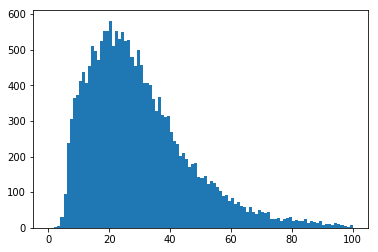

In [10]:
d = plt.hist(line_lens, bins=100, range=(0, 100))

In [11]:
max_len = 80

In [12]:
tdata = np.array([(([emptyidx]*max_len) + text)[-max_len:] for text in wordid_train_data])

In [13]:
tdata[1]

array([400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
       400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
       400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
       400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
       400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
       400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
       400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
       400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
       400000,     20,    332,    442,   1858,      4,    285,     12,
            0,  43888,    414,     30,      7,   6575,   3895,      2])

In [14]:
glove_vecs.shape

(400001, 300)

# Transfrom labels

In [15]:
authors = sorted(list(set(raw_train_labels)))

In [16]:
author_indices = dict((a, i) for i, a in enumerate(authors))
indices_autor = dict((i, a) for i, a in enumerate(authors))

In [17]:
tlabels = to_categorical(list(map(lambda l: author_indices[l], raw_train_labels)))

In [18]:
number_of_classes = len(authors)

# Split data to train and validation

In [19]:
from sklearn.model_selection import train_test_split

train_data, valid_data, train_labels, valid_labels  = train_test_split(tdata, tlabels, test_size=0.05, shuffle=True)

In [20]:
print(train_data.shape, valid_data.shape, train_labels.shape, valid_labels.shape)

(18600, 80) (979, 80) (18600, 3) (979, 3)


# Create model

In [21]:
vocab_size = len(glove_words)

In [56]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout, TimeDistributed,Bidirectional, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

n_fac = 512 
bs = 612
n_hidden=512

model=Sequential([
        Embedding(vocab_size, glove_vec_len, batch_input_shape=(None,max_len),weights=[glove_vecs], trainable=False),
        BatchNormalization(),
        Bidirectional(GRU(n_hidden,input_shape=(None,n_fac),return_sequences=True)),
        LeakyReLU(alpha=0.2),
        #GRU(n_hidden, dropout=0.3, recurrent_dropout=0.1, return_sequences=True),
        #GRU(n_hidden, dropout=0.3, recurrent_dropout=0.1),
        Dense(1024, activation='relu'),
        Dropout(0.9),
        Dense(number_of_classes, activation='softmax')
    ])



In [57]:
opt = Nadam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [58]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [59]:
model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), batch_size=bs, epochs=100,callbacks=[earlystop])

ValueError: Error when checking target: expected dense_23 to have 3 dimensions, but got array with shape (18600, 3)

In [ ]:
valid_preds = model.predict(valid_data)

In [ ]:
valid_preds

In [41]:
idx = 5
print(valid_labels[idx])
print(valid_preds[idx])
print(' '.join([w for w in map(lambda x: glove_words[x], valid_data[idx]) if w != '####']))

[ 1.  0.  0.]
[ 0.83295828  0.12181897  0.04522278]
at each end of its axis this screw is supported by pillars of hollow brass tube descending from the hoop .


In [30]:
nevermore = np.zeros((1,80))

In [31]:
nevermore[0,0] = glove_wordidx['nevermore']


In [32]:
model.predict(nevermore)

array([[ 0.4963308 ,  0.31137946,  0.19228974]], dtype=float32)

In [34]:
raw_train_data[0]
raw

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'